In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
import sys
import math
from datetime import datetime
#import relu
from torch.nn import functional as F
sys.path.append('../models')
sys.path.append('../utils')
sys.path.append('../data_func')
from sharpe_loss import SharpeLoss
from data_helper_functions import create_study_periods,create_tensors
from transformer_model import TimeSeriesTransformer,ScaledMultiHeadAttention

We can train multiple transformer models. 1. Cross-sectional-Median Target 2. Raw-returns target 3. Sharpe ratio objective 4. Selective Transformer Model with all of the previous iterations. We can also consider Stochastic Attention, using Attention to calculate a confidence score, and building a confidence model as a first pass. (Cross-sectional median confidence as first filter, and then use the confidence score to select the top 10% of stocks to train on.)
All in all, because of compute the goal shouldn't be to train a model that generates an insane sharpe, but show the potential of Selective ML in portfolio building and how it improves over current SOTA methods. The paper should mostly be an analysis on what types of stocks the model does not learn from/ abstains from.  We can't afford to hyper-parameter tune a lot.

In [2]:
# df=pd.read_csv('../data/crsp_ff_adjusted.csv')
# #drop unamed 0
# df['date'] = pd.to_datetime(df['date'])
# df.dropna(subset=['RET'],inplace=True)
# df=df.drop(columns='Unnamed: 0')
# df 

In [3]:
# #get just 2014
# df=df[df['date'].dt.year==2014]

In [4]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader

np.random.seed(42)  # for reproducibility

def generate_individual_stock_data(num_days=1000, pattern='sine', start_price=100):
    if pattern == 'random':
        price_changes = np.random.randn(num_days) * 0.5 + 0.1  # daily returns
        prices = np.cumsum(price_changes) + start_price  # price series
    elif pattern == 'sine':
        x = np.linspace(0, 20, num_days)
        prices = np.sin(x) * 10 + start_price
    elif pattern == 'exponential':
        x = np.linspace(0, 5, num_days)
        prices = np.exp(x) + start_price

    return prices

def process_stock_data(prices, sequence_length=250):
    log_returns = np.log(prices[1:] / prices[:-1])
    data = []
    labels = []
    for i in range(len(log_returns) - sequence_length):
        data.append(log_returns[i:i + sequence_length])
        labels.append(log_returns[i + sequence_length])
    return np.array(data), np.array(labels)

def standardize_data(data):
    mean = np.mean(data)
    std = np.std(data)
    return (data - mean) / std, mean, std

def apply_standardization_to_data(data, mean, std):
    return (data - mean) / std

# Set parameters
num_days = 1000
sequence_length = 250
train_period = 750

# Patterns
patterns = ['random', 'sine', 'exponential']

# Generate data for each pattern
stocks_data = []
for pattern in patterns:
    prices = generate_individual_stock_data(num_days=num_days, pattern=pattern, start_price=100)
    stock_data, stock_labels = process_stock_data(prices, sequence_length=sequence_length)
    stocks_data.append((stock_data[:train_period], stock_labels[:train_period],
                        stock_data[train_period-sequence_length:],
                        stock_labels[train_period-sequence_length:]))


train_data_flat = np.concatenate([data[0] for data in stocks_data]).flatten()
train_data_standardized, mean, std = standardize_data(train_data_flat)

# Apply standardization to each split using the calculated mean and std
stocks_data_standardized = []
for stock_data, stock_labels, test_data, test_labels in stocks_data:
    stock_data = apply_standardization_to_data(stock_data, mean, std)
    test_data = apply_standardization_to_data(test_data, mean, std)
    stocks_data_standardized.append((stock_data, stock_labels, test_data, test_labels))

# Prepare the final datasets with standardized data
train_data_combined = np.concatenate([data[0] for data in stocks_data_standardized], axis=0)
train_labels_combined = np.concatenate([data[1] for data in stocks_data_standardized], axis=0)
test_data_combined = np.concatenate([data[2] for data in stocks_data_standardized], axis=0)
test_labels_combined = np.concatenate([data[3] for data in stocks_data_standardized], axis=0)

# Convert to tensors
train_data_tensor = torch.tensor(train_data_combined, dtype=torch.float32).unsqueeze(-1)
train_labels_tensor = torch.tensor(train_labels_combined, dtype=torch.float32)
test_data_tensor = torch.tensor(test_data_combined, dtype=torch.float32).unsqueeze(-1)
test_labels_tensor = torch.tensor(test_labels_combined, dtype=torch.float32)

train_test_splits = [(train_data_tensor, train_labels_tensor, test_data_tensor, test_labels_tensor)]



In [5]:
train_test_splits

[(tensor([[[-0.0823],
           [ 1.6837],
           [ 3.6263],
           ...,
           [ 3.3646],
           [ 0.8767],
           [-2.1488]],
  
          [[ 1.6837],
           [ 3.6263],
           [-0.2973],
           ...,
           [ 0.8767],
           [-2.1488],
           [ 1.8093]],
  
          [[ 3.6263],
           [-0.2973],
           [-0.2973],
           ...,
           [-2.1488],
           [ 1.8093],
           [ 3.9680]],
  
          ...,
  
          [[ 0.4472],
           [ 0.4496],
           [ 0.4520],
           ...,
           [ 1.1155],
           [ 1.1183],
           [ 1.1210]],
  
          [[ 0.4496],
           [ 0.4520],
           [ 0.4543],
           ...,
           [ 1.1183],
           [ 1.1210],
           [ 1.1237]],
  
          [[ 0.4520],
           [ 0.4543],
           [ 0.4567],
           ...,
           [ 1.1210],
           [ 1.1237],
           [ 1.1265]]]),
  tensor([0.0045, 0.0093, 0.0049,  ..., 0.0030, 0.0030, 0.0030]),
  ten

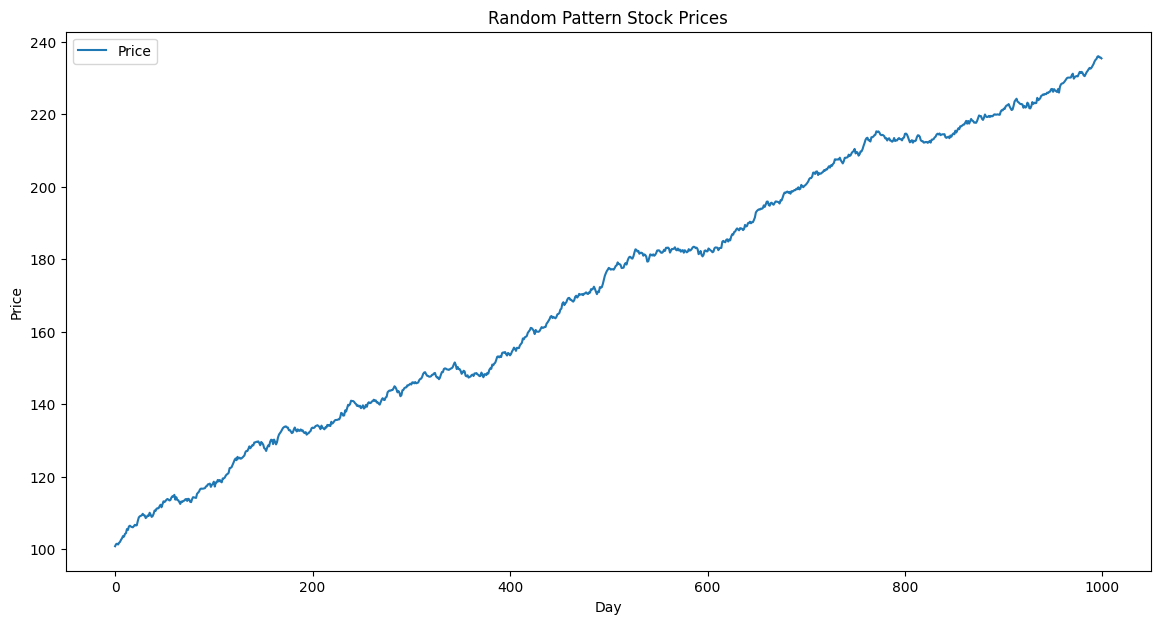

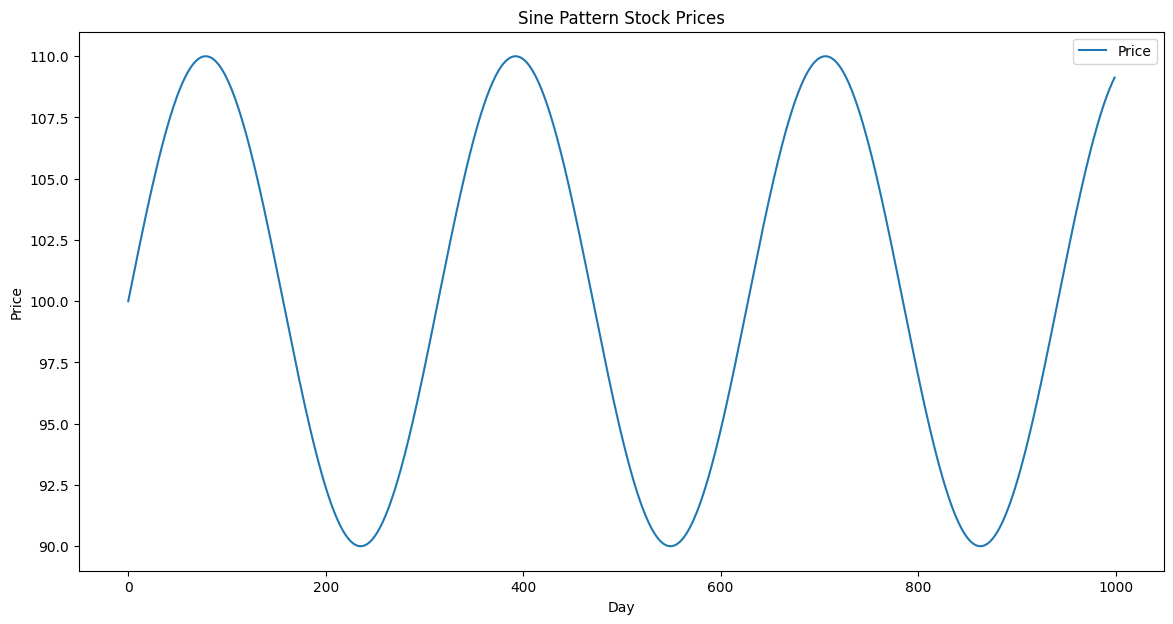

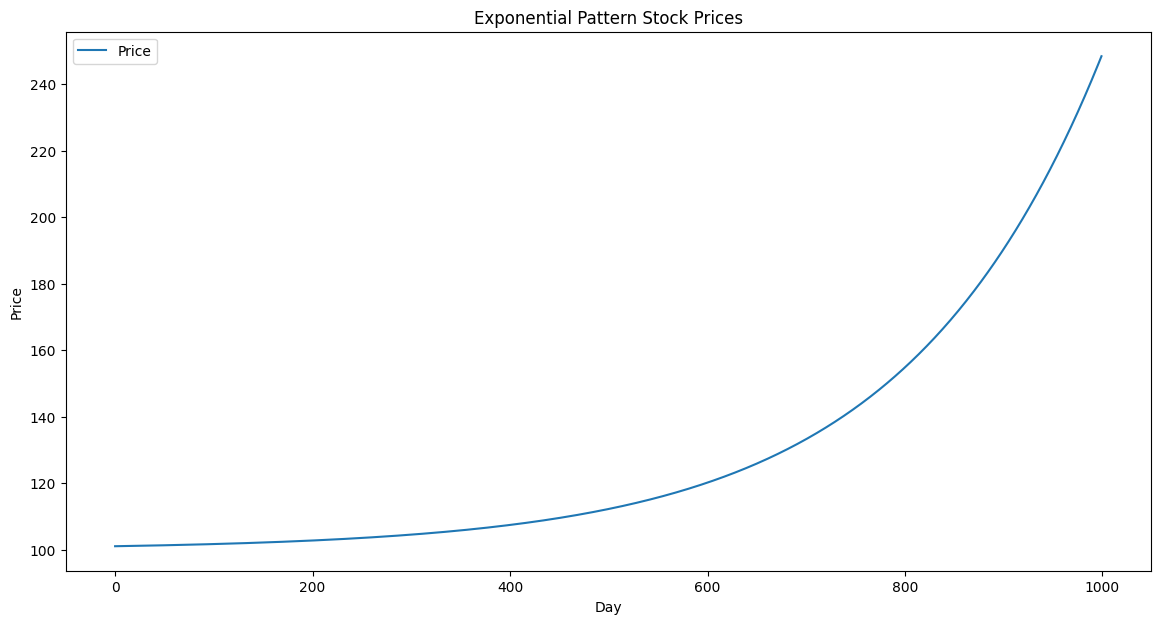

In [6]:
import matplotlib.pyplot as plt

# Add this function to plot the generated stock data
def plot_stock_data(prices, title='Stock Prices'):
    plt.figure(figsize=(14, 7))
    plt.plot(prices, label='Price')
    plt.title(title)
    plt.xlabel('Day')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

# Generate and plot data for each pattern
for pattern in patterns:
    prices = generate_individual_stock_data(num_days=num_days, pattern=pattern, start_price=100)
    plot_stock_data(prices, title=f'{pattern.capitalize()} Pattern Stock Prices')


In [7]:
#Optional parameter target_type: 'cross_sectional_median(default)','buckets(10 buckets)','raw_returns'.
# study_periods=create_study_periods(df,n_periods=23,window_size=240,trade_size=250,train_size=750,forward_roll=250,start_date=datetime(1990,1,1),end_date=datetime(2015,12,31),apply_wavelet_transform=True)

In [8]:
# import matplotlib.pyplot as plt
# import numpy as np

# # Assuming 'study_periods' is a list of tuples containing (train_df, trade_df)
# # and each DataFrame has the columns 'date', 'TICKER', 'RET', among others.

# # We'll select a few random tickers and plot their 'RET' values
# def plot_random_tickers_from_study_period(study_period, num_tickers=3):
#     train_df, trade_df = study_period

#     # Get unique tickers from the training period
#     unique_tickers = train_df['TICKER'].unique()
    
#     # Randomly select a few tickers
#     selected_tickers = np.random.choice(unique_tickers, num_tickers, replace=False)
    
#     # Plotting
#     plt.figure(figsize=(14, 7))
#     for ticker in selected_tickers:
#         # Filter the DataFrame for the selected ticker
#         ticker_train_data = train_df[train_df['TICKER'] == ticker]
#         ticker_trade_data = trade_df[trade_df['TICKER'] == ticker]
        
#         # Plot training period returns
#         plt.plot(ticker_train_data['date'], ticker_train_data['RET'], label=f'{ticker} - Training')
        
#         # Plot trading period returns
#         plt.plot(ticker_trade_data['date'], ticker_trade_data['RET'], '--', label=f'{ticker} - Trading')
    
#     plt.title('Random Ticker Returns from a Study Period')
#     plt.xlabel('Date')
#     plt.ylabel('Return')
#     plt.legend()
#     plt.grid(True)
#     plt.show()

# # Now we'll plot the returns for a few tickers from the first study period
# plot_random_tickers_from_study_period(study_periods[0], num_tickers=3)


In [9]:
# train_test_splits,task_types=create_tensors(study_periods)

In [10]:
#Optional code to verify tensor shapes
for train_data, train_labels, test_data, test_labels in train_test_splits:
    print(train_data.shape, train_labels.shape, test_data.shape, test_labels.shape)

torch.Size([2247, 250, 1]) torch.Size([2247]) torch.Size([747, 250, 1]) torch.Size([747])


In [11]:
task_types=['regression']

In [12]:
#Figure out how big model is when saved
#Ensure model is actually learning, look into loss curves
#Fournier Transform stock data to get more simplistic data to learn from to test
#If using sharpe loss you have to lead/ lag data or something to find actual next day return for stock you pick
#Model should be learning how to be a portfolio constructer (learn to reject stocks from its portfolio)
#Test toydataset on hugging face model
#Look more into deep gamblers
#Maybe turn it back into a classification problem (above/below cross-sectional median) and switch objective to pick winners instead of overall sharpe
#Yes!, and try pre-trained hugging face model on data

#ALSO FIX BATCH SIZE ERROR

In [13]:
train_test_splits[0][0].shape

torch.Size([2247, 250, 1])

In [14]:
# Check if CUDA, MPS, or CPU should be used
if torch.cuda.is_available():
    device = torch.device("cuda")
# elif torch.backends.mps.is_available():
#     device = torch.device("mps")
else:
    device = torch.device("mps")

print("Using device:", device)
best_model_path = "best_model.pth" 
model = TimeSeriesTransformer(d_model=32, num_heads=4, d_ff=128, num_encoder_layers=2, 
                               dropout=.1,task_type=task_types[0]).to(device)
# model = TimeSeriesTransformerModel(config)

# Loss depends on target, MAE for returns, Cross Entropy for above/below cross-sectional median. Also have selective loss in utils
if task_types[0] == 'classification':
    criterion = nn.NLLLoss()
else:
    criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

n_epochs = 100
patience = 5
best_loss = np.inf
counter = 0
batch_size=64
for epoch in range(n_epochs):
    model.train()
    total_train_loss = 0.0
    total_val_loss = 0.0

    for train_data, train_labels, val_data, val_labels in tqdm(train_test_splits):
        train_dataset = TensorDataset(train_data, train_labels)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

        val_dataset = TensorDataset(val_data, val_labels)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
        #reshape to batch,sequence,d_model
        
        # Access the batch size from the train_loader
        batch_size = train_loader.batch_size
        sequence_length = train_loader.dataset.tensors[0].size(1)

        train_loss = 0.0
        for data, labels in train_loader:
            data, labels = data.to(device), labels.to(device)
            lookahead_mask = TimeSeriesTransformer.create_lookahead_mask(data.size(1)).to(device)
            optimizer.zero_grad()
            outputs,_ = model(data,src_mask=lookahead_mask)
            if task_types[0] == 'classification':
                labels = labels.long()  # Adjusted here to use the look-ahead mask
            loss = criterion(outputs, labels)  # Adjust based on your specific use case
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * data.size(0)

        total_train_loss += train_loss / len(train_loader.dataset)

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for data, labels in val_loader:
                data, labels = data.to(device), labels.to(device)
                lookahead_mask = TimeSeriesTransformer.create_lookahead_mask(data.size(1)).to(device)
                outputs,_ = model(data,src_mask=lookahead_mask)
                if task_types[0] == 'classification':
                    labels = labels.long() # Adjusted here to use the look-ahead mask
                loss = criterion(outputs, labels)  # Adjust based on your specific use case
                val_loss += loss.item() * data.size(0)

        total_val_loss += val_loss / len(val_loader.dataset)

    average_train_loss = total_train_loss / len(train_test_splits)
    average_val_loss = total_val_loss / len(train_test_splits)
    
    print(f'Epoch {epoch+1}/{n_epochs}, '
          f'Average Train Loss: {average_train_loss:.4f}, '
          f'Average Validation Loss: {average_val_loss:.4f}')

    if average_val_loss < best_loss:
        best_loss = average_val_loss
        torch.save(model.state_dict(), best_model_path)
        counter = 0
    else:
        counter += 1

    if counter == patience:
        print('Early stopping!')
        break

best_model_state = torch.load(best_model_path, map_location=device)
model.load_state_dict(best_model_state)

Using device: mps


  0%|          | 0/1 [01:30<?, ?it/s]


KeyboardInterrupt: 

In [43]:
# test_data,test_labels=train_test_splits[0][2],train_test_splits[0][3]

In [44]:
# test_data.shape

torch.Size([44982, 240, 1])

In [14]:
test_data_tensor = torch.tensor(test_data, dtype=torch.float32)
test_labels_tensor = torch.tensor(test_labels, dtype=torch.float32)

/var/folders/bm/bm_nkxfx3w1303dr6gyz9cg00000gn/T/ipykernel_75967/2282182767.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_data_tensor = torch.tensor(test_data, dtype=torch.float32)
/var/folders/bm/bm_nkxfx3w1303dr6gyz9cg00000gn/T/ipykernel_75967/2282182767.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_labels_tensor = torch.tensor(test_labels, dtype=torch.float32)


Accuracy: 0.5716508825752523
              precision    recall  f1-score   support

         0.0       0.61      0.49      0.54     23535
         1.0       0.54      0.67      0.60     21447

    accuracy                           0.57     44982
   macro avg       0.58      0.58      0.57     44982
weighted avg       0.58      0.57      0.57     44982

Accuracy: 0.5716508825752523
              precision    recall  f1-score   support

         0.0       0.61      0.49      0.54     23535
         1.0       0.54      0.67      0.60     21447

    accuracy                           0.57     44982
   macro avg       0.58      0.58      0.57     44982
weighted avg       0.58      0.57      0.57     44982



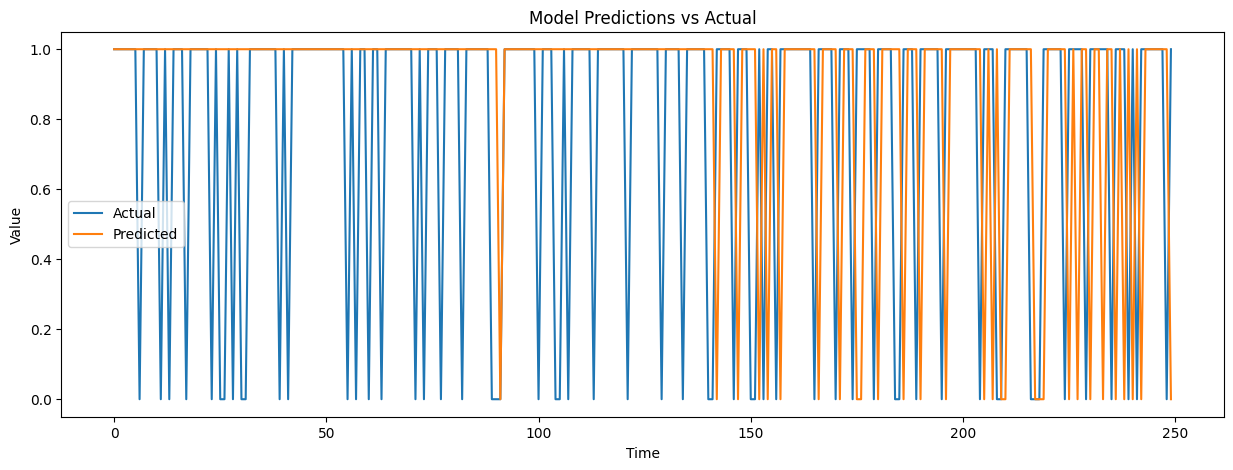

In [15]:
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, accuracy_score, classification_report
import numpy as np

# # Assuming your model is for regression. Change this part if it's for classification.
# def evaluate_model(model, test_loader):
#     model.eval()
#     predictions = []
#     actuals = []
#     with torch.no_grad():
#         for data, labels in test_loader:
#             data, labels = data.to(device), labels.to(device)
#             outputs = model(data)
#             predictions.extend(outputs.cpu().numpy())
#             actuals.extend(labels.cpu().numpy())

#     return np.array(predictions), np.array(actuals)
# import numpy as np
from sklearn.metrics import accuracy_score, classification_report

def evaluate_model_class(model, test_loader):
    model.eval()
    predictions = []
    actuals = []
    with torch.no_grad():
        for data, labels in test_loader:
            data, labels = data.to(device), labels.to(device)
            outputs = model(data)

            # Convert log probabilities to probabilities
            probs = torch.exp(outputs)

            # For binary classification, consider the probability of the positive class
            # preds = (probs[:, 1] > 0.5).type(torch.int) # if binary classification
            # For multi-class classification, use argmax to get the predicted class
            preds = torch.argmax(probs, dim=1) # if multi-class classification

            predictions.extend(preds.cpu().numpy())
            actuals.extend(labels.cpu().numpy())

    # Convert to NumPy arrays for further analysis
    predictions = np.array(predictions)
    actuals = np.array(actuals)

    # Calculate accuracy or other metrics as needed
    accuracy = accuracy_score(actuals, predictions)
    print(f'Accuracy: {accuracy}')
    print(classification_report(actuals, predictions))

    return predictions, actuals



# Create DataLoader for test data
test_dataset = TensorDataset(test_data_tensor, test_labels_tensor)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Evaluate the model
predictions, actuals = evaluate_model_class(model, test_loader)

# Calculate performance metrics
if model.task_type == 'regression':
    mse = mean_squared_error(actuals, predictions)
    print(f'Mean Squared Error: {mse}')
    # Can also calculate RMSE, MAE, etc.
elif model.task_type == 'classification':
    if len(predictions.shape) == 2 and predictions.shape[1] == 2:
        predictions = predictions[:, 1]  # Keep only the probabilities for class 1

    # Round the probabilities to get binary predictions
    binary_predictions = predictions.round()

    # Ensure actuals is a 1D array
    actuals = actuals.flatten()
    accuracy = accuracy_score(actuals, binary_predictions)
    print(f'Accuracy: {accuracy}')
    print(classification_report(actuals, binary_predictions))

# Plotting predictions vs actuals for a subset of the test data
plt.figure(figsize=(15, 5))
plt.plot(actuals[:250], label='Actual')
plt.plot(predictions[:250], label='Predicted')
plt.title('Model Predictions vs Actual')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()


In [50]:
predictions

array([[ 0.16815382],
       [ 0.17151144],
       [ 0.16502017],
       ...,
       [-0.01446453],
       [ 0.01244107],
       [ 0.0100327 ]], dtype=float32)

In [51]:
actuals

array([ 0.002532,  0.004247,  0.007937, ..., -0.013261, -0.013586,
       -0.003615], dtype=float32)

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = TimeSeriesTransformer(d_model=64, num_heads=8, d_ff=256, num_encoder_layers=2, 
#                                dropout=.1, max_len=240,task_type='classification')
model.load_state_dict(torch.load('best_model.pth',map_location=torch.device('cpu')) )
model.eval()

in_sample_long_portfolios = pd.DataFrame()
out_of_sample_long_portfolios = pd.DataFrame()

in_sample_short_portfolios = pd.DataFrame()
out_of_sample_short_portfolios = pd.DataFrame()

k = 10  # Number of top assets to select in portfolios

for train_data, train_labels, val_data, val_labels in tqdm(train_test_splits):
    # Here, train_data, val_data are your training and validation data respectively
    

    train_mask = ScaledMultiHeadAttention.create_look_ahead_mask(batch_size=train_data.size(0), sequence_length=train_data.size(1))
    val_mask = ScaledMultiHeadAttention.create_look_ahead_mask(batch_size=val_data.size(0), sequence_length=val_data.size(1))

    with torch.no_grad():
        train_predictions = model(train_data.to(device), src_mask=train_mask.to(device))
        val_predictions = model(val_data.to(device), src_mask=val_mask.to(device))

        train_probs = torch.softmax(train_predictions, dim=1)[:, 1].cpu().numpy()
        val_probs = torch.softmax(val_predictions, dim=1)[:, 1].cpu().numpy()

    # Assuming you have a dataframe or similar structure to hold the date and TICKER information
    train_df['predicted_prob'] = train_probs
    val_df['predicted_prob'] = val_probs

    # In-Sample Portfolio Construction
    for date in train_df['date'].unique():
        date_data = train_df[train_df['date'] == date].sort_values(by='predicted_prob', ascending=False)
        
        long_tickers = date_data.head(k)
        short_tickers = date_data.tail(k)
        
        in_sample_long_portfolios = pd.concat([in_sample_long_portfolios, long_tickers])
        in_sample_short_portfolios = pd.concat([in_sample_short_portfolios, short_tickers])

    # Out-of-Sample Portfolio Construction
    for date in val_df['date'].unique():
        date_data = val_df[val_df['date'] == date].sort_values(by='predicted_prob', ascending=False)
        
        long_tickers = date_data.head(k)
        short_tickers = date_data.tail(k)
        
        out_of_sample_long_portfolios = pd.concat([out_of_sample_long_portfolios, long_tickers])
        out_of_sample_short_portfolios = pd.concat([out_of_sample_short_portfolios, short_tickers])

# At this point, in_sample_long_portfolios, out_of_sample_long_portfolios, etc. hold your portfolios



  0%|          | 0/1 [00:00<?, ?it/s]

: 

In [ ]:
in_sample_long_portfolios.to_csv('../data/transformer_results/in_sample_long_portfolios.csv')
in_sample_short_portfolios.to_csv('../data/transformer_results/in_sample_short_portfolios.csv')
out_of_sample_long_portfolios.to_csv('../data/transformer_results/out_of_sample_long_portfolios.csv')
out_of_sample_short_portfolios.to_csv('../data/transformer_results/out_of_sample_short_portfolios.csv')